In [1]:
import sys
sys.path.append('../../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from astropy import units as u
from matplotlib.lines import Line2D
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube
import cmasher as cmr

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

import warnings
warnings.filterwarnings('ignore')


In [2]:
outflowB_vel_file = fits.open('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
outflowB_vel = outflowB_vel_file[0].data

alpha = 30 # 
incl = 78  # deg

In [3]:
# realistic maximum blueshifted velocity (under 600 km/s)
max_blue = np.min(outflowB_vel[(np.abs(outflowB_vel) > 500) & (np.abs(outflowB_vel) < 600)])
max_blue_deproj = max_blue / np.abs(np.cos((incl - alpha)*(np.pi / 180)))

print(max_blue)
print(max_blue_deproj)

-593.9307986086853
-887.6156507630398


In [4]:
def deproj_factor_wrt_phi(alpha, phi, incl):
    
    alpha_new = alpha * np.sin(phi*(np.pi / 180))
    
    deproj_factor = np.cos((incl + alpha_new)*(np.pi / 180))
    
    return(deproj_factor)

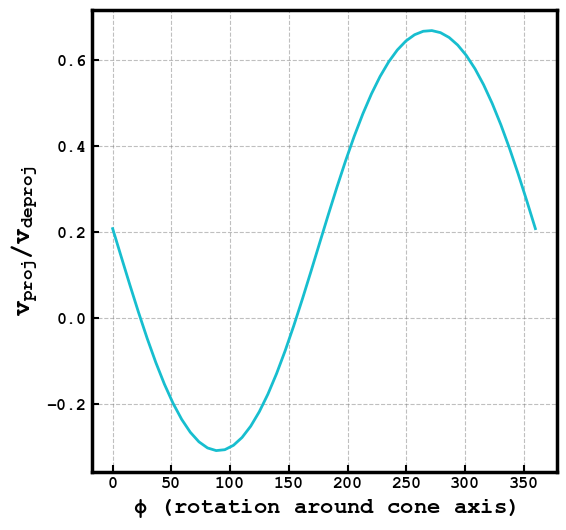

In [5]:
phi_list = np.linspace(0, 360)
deproj_factor = deproj_factor_wrt_phi(alpha, phi_list, incl)

f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(phi_list, deproj_factor, color='tab:cyan', lw=2)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax.grid(ls='--',color='gray', alpha=0.5)
ax.set_ylabel('v$_{proj}$/v$_{deproj}$', fontsize=18)
ax.set_xlabel('$\\phi$ (rotation around cone axis)', fontsize=16)
plt.show()

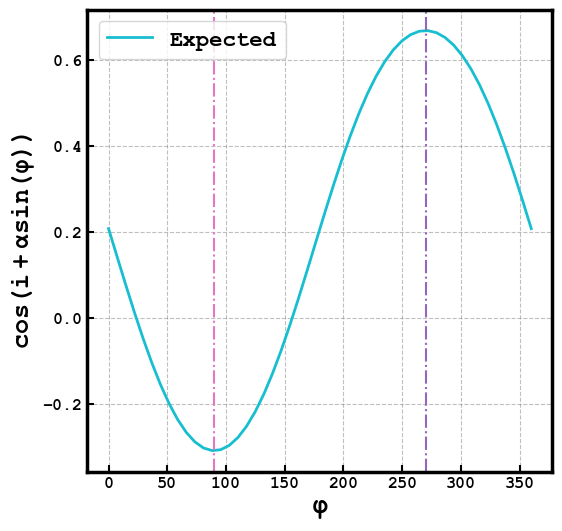

In [6]:
phi_list = np.linspace(0, 360)
deproj_factor = deproj_factor_wrt_phi(alpha, phi_list, incl)

f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(phi_list, deproj_factor, color='tab:cyan', lw=2, label='Expected')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax.grid(ls='--',color='gray', alpha=0.5)
ax.axvline(x=90, ls='-.',color='tab:pink')
ax.axvline(x=270, ls='-.',color='tab:purple')
ax.set_ylabel('$cos(i + \\alpha sin(\\varphi))$', fontsize=18)
ax.set_xlabel('$\\varphi$', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [7]:
# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 22,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

In [9]:
NIIfilename = '../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
NII = fits.open(NIIfilename)[1]

def get_offset(dat, w):
    
    center_pix = w.pixel_to_world(dat.shape[1]//2, dat.shape[0]//2)
    
    ra_hr = center_pix.ra.hms[0]
    ra_min = center_pix.ra.hms[1]
    ra_sec = center_pix.ra.hms[2]
    ra_hms = '%s$^{h}$%s$^{m}$%s$^{s}$' % (int(ra_hr), int(ra_min), np.round(ra_sec,2))
    
    dec_deg = center_pix.dec.dms[0]
    dec_min = center_pix.dec.dms[1]
    dec_sec = center_pix.dec.dms[2]
    dec_dms = "%s$^{o}$%s'%s$''$" % (int(dec_deg), int(np.abs(dec_min)), np.round(np.abs(dec_sec),2))

    return(ra_hms, dec_dms)

ra_hms, dec_dms = get_offset(NII.data, wcs.WCS(NII.header, naxis=2).celestial)
pixscale = 0.2  # arcsec
x_lower = -(NII.shape[2]*pixscale)//2
x_upper = (NII.shape[2]*pixscale)//2
y_lower = -(NII.shape[1]*pixscale)//2
y_upper = (NII.shape[1]*pixscale)//2
extent=[x_lower,x_upper, y_lower,y_upper]


In [75]:
from astropy.wcs.utils import pixel_to_skycoord
import pvextractor


outflowB_3D = np.empty((1,outflowB_vel.shape[0],outflowB_vel.shape[1]))
outflowB_3D[:,:,:] = outflowB_vel
outflowB_wcs = SpectralCube(outflowB_3D, wcs=wcs.WCS(NII))

y_coord = 235
x_coord = 235

length = 150.*0.2 # pixels*arcsec/pixel
pa = 45  # measuring N-S
width = 20*0.2

coord = pixel_to_skycoord(x_coord, y_coord, wcs=wcs.WCS(NII))
path = pvextractor.PathFromCenter(center=coord,
                    length=length * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
vels = pvextractor.extract_pv_slice(cube=outflowB_wcs, path=path)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
vels_list = [float(vels.data[:,i]) for i in range(vels.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
spatial_axis_deg = wcs.WCS(vels.header).array_index_to_world_values(np.zeros(vels.shape[1]), np.arange(vels.shape[1]))
spatial_axis_arcsec = (spatial_axis_deg[0] * u.deg).to(u.arcsec).to_value()

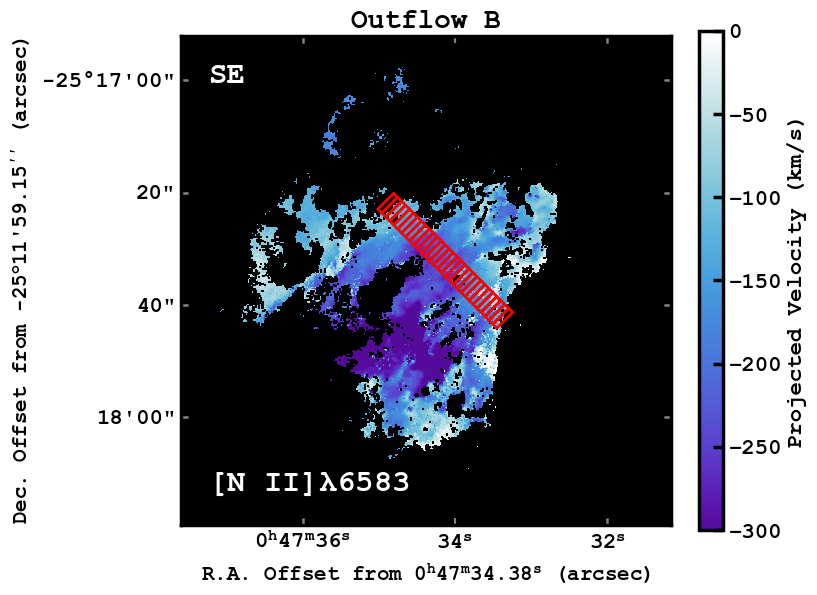

In [76]:
from matplotlib.patches import Rectangle

cmap = cmr.get_sub_cmap('cmr.fusion_r', 0.1, 0.50)
plt.figure(figsize=(7,7))

ax = plt.subplot(1, 1, 1, projection=wcs.WCS(NII, naxis=2))

im = ax.imshow(outflowB_vel, origin='lower', vmin=-300, vmax=0, cmap=cmap)
path.show_on_axis(ax, spacing=5, edgecolor='red', linestyle='-',linewidth=2)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='gray')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_xlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=15)
ax.set_ylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=15)
ax.set_facecolor('black')
ax.set_title('Outflow B', fontsize=20)

bar = plt.colorbar(im, fraction=0.046)
bar.set_label('Projected Velocity (km/s)', fontsize=16)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('[N II]$\lambda6583$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

# ax.set_yticks([-40, -20, 0, 20, 40])

plt.show()

In [179]:
y_coord

235

In [182]:
phi_list = np.linspace(180, 360, len(vels_list))
deproj_factor = deproj_factor_wrt_phi(alpha, phi_list, incl)

h_pc = 235*3.395 # full height of cone in pc; y-axis length in pixel number times pc per pixel

x = h_pc * np.tan(alpha * (np.pi / 180)) * np.cos(phi_list)

x_sorted = np.sort(x)
len(x_sorted)

150

In [124]:
avg_vels_list = []
i = 0
while i < (len(vels_list)):
    avg_vels_list.append(np.mean(vels_list[i:i+6]))
    i+=6

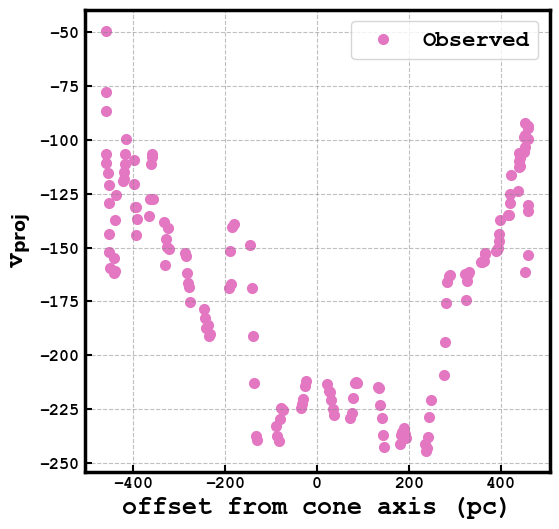

In [190]:
phi_list = np.linspace(0, 360)
deproj_factor = deproj_factor_wrt_phi(alpha, phi_list, incl)

f, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.plot(phi_list, deproj_factor, color='tab:cyan', lw=2, label='Expected')
ax.scatter(x_sorted, vels_list, color='tab:pink', lw=2, label='Observed')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax.grid(ls='--',color='gray', alpha=0.5)
# ax.axvline(x=90, ls='-.',color='tab:pink')
# ax.axvline(x=270, ls='-.',color='tab:purple')
ax.set_ylabel(r'v$_{\rm proj}$', fontsize=18)
ax.set_xlabel('offset from cone axis (pc)', fontsize=18)
plt.legend(fontsize=16)
plt.show()

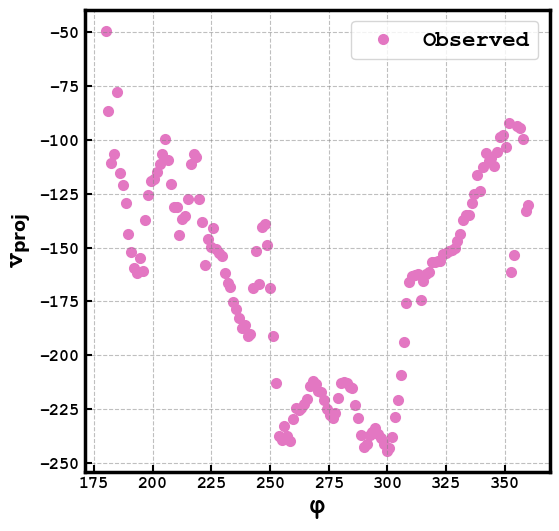

In [128]:
phi_list = np.linspace(0, 360)
deproj_factor = deproj_factor_wrt_phi(alpha, phi_list, incl)

f, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.plot(phi_list, deproj_factor, color='tab:cyan', lw=2, label='Expected')
ax.scatter(np.linspace(180,360,150), vels_list, color='tab:pink', lw=2, label='Observed')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax.grid(ls='--',color='gray', alpha=0.5)
# ax.axvline(x=90, ls='-.',color='tab:pink')
# ax.axvline(x=270, ls='-.',color='tab:purple')
ax.set_ylabel(r'v$_{\rm proj}$', fontsize=18)
ax.set_xlabel('$\\varphi$', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [ ]:
phi_list = np.linspace(0, 360)
deproj_factor = deproj_factor_wrt_phi(alpha, phi_list, incl)

f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(phi_list, deproj_factor, color='tab:cyan', lw=2, label='Expected')


ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax.grid(ls='--',color='gray', alpha=0.5)
ax.axvline(x=90, ls='-.',color='tab:pink')
ax.axvline(x=270, ls='-.',color='tab:purple')
ax.set_ylabel('$cos(i + \\alpha sin(\\varphi))$', fontsize=18)
ax.set_xlabel('$\\varphi$', fontsize=20)
plt.legend(fontsize=16)
plt.show()

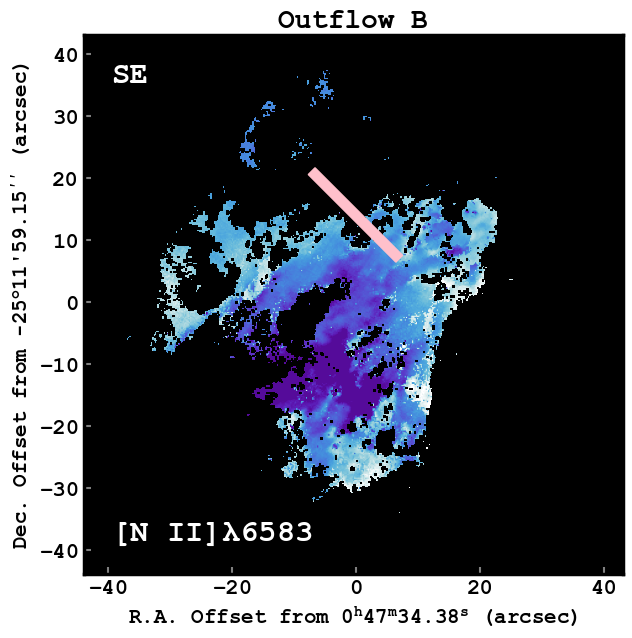

In [14]:
from matplotlib.patches import Rectangle

cmap = cmr.get_sub_cmap('cmr.fusion_r', 0.1, 0.50)
plt.figure(figsize=(7,7))

ax = plt.subplot(1, 1, 1)
ax.imshow(outflowB_vel, origin='lower', vmin=-300, vmax=0, cmap=cmap, alpha=0, zorder=0)  # stupid workaround
test = Rectangle((x_coord, y_coord), width, length, angle=pa, rotation_point='xy', 
                 color='pink', zorder=10)
ax.add_artist(test)

im = ax.imshow(outflowB_vel, origin='lower', vmin=-300, vmax=0, cmap=cmap,extent=extent, zorder=1)
ax.set_title('', fontsize=18)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='gray')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_xlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=15)
ax.set_ylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=15)
ax.set_facecolor('black')
ax.set_title('Outflow B', fontsize=20)

x_coord_arcsec = ((x_coord-218)*pixscale)
y_coord_arcsec = ((y_coord-218)*pixscale)

test = Rectangle((x_coord_arcsec,y_coord_arcsec), width, length, angle=45, rotation_point='xy', 
                 color='pink', zorder=10)
ax.add_artist(test)

# bar = plt.colorbar(im, fraction=0.046)
# bar.set_label('Projected Velocity (km/s)', fontsize=16)
# bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('[N II]$\lambda6583$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

# path.show_on_axis(ax, spacing=30, edgecolor='red', linestyle='-',linewidth=2)

# ax.set_yticks([-40, -20, 0, 20, 40])

plt.show()